## Exercise 9: Advanced Image Registration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage import img_as_ubyte
from IPython.display import clear_output

In [5]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

In [6]:
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

In [7]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

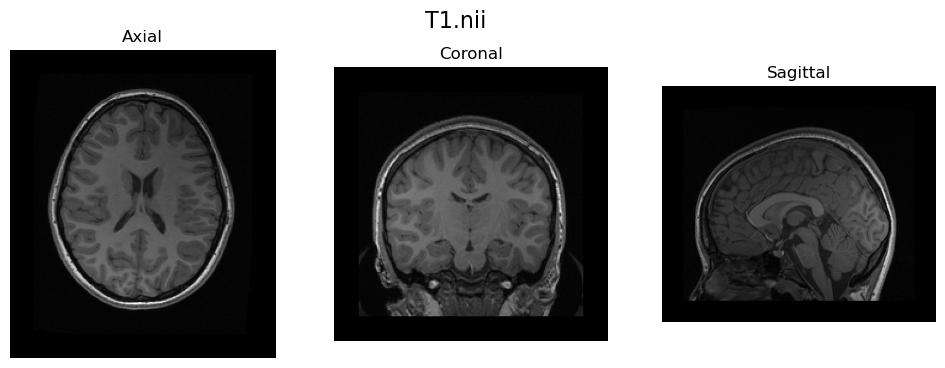

In [8]:
# exercise 1: load TmgT1.nii
dir_in = 'data/'
vol_sitk = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Display the volume
imshow_orthogonal_view(vol_sitk, title='T1.nii')

In [9]:
# exercise 2: write a function
def rotation_matrix(pitch, roll, yaw):
    # input in radians
    Rx = np.array([[1, 0, 0, 0], 
                   [0, np.cos(pitch), -np.sin(pitch), 0],
                   [0, np.sin(pitch), np.cos(pitch), 0], 
                   [0, 0, 0, 1]])
    Ry = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                   [0, 1, 0, 0], 
                   [-np.sin(roll), 0, np.cos(roll), 0], 
                   [0, 0, 0, 1]])
    Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0, 0,],
                   [np.sin(yaw), np.cos(yaw), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    R = np.dot(np.dot(Rx, Ry), Rz)
    return R

pitch=25
rot_mat = rotation_matrix(np.deg2rad(pitch),0,0)
print(rot_mat)

[[ 1.          0.          0.          0.        ]
 [ 0.          0.90630779 -0.42261826  0.        ]
 [ 0.          0.42261826  0.90630779  0.        ]
 [ 0.          0.          0.          1.        ]]


In [10]:
# exercise 3: apply rotation to image

# Define the roll rotation in radians
angle = 25  # degrees
pitch_radians = np.deg2rad(angle)

#  Set the rotation 
centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

# Create the Affine transform 
transform = sitk.AffineTransform(3)
transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(ImgT1_A, dir_in + 'ImgT1_A.nii')

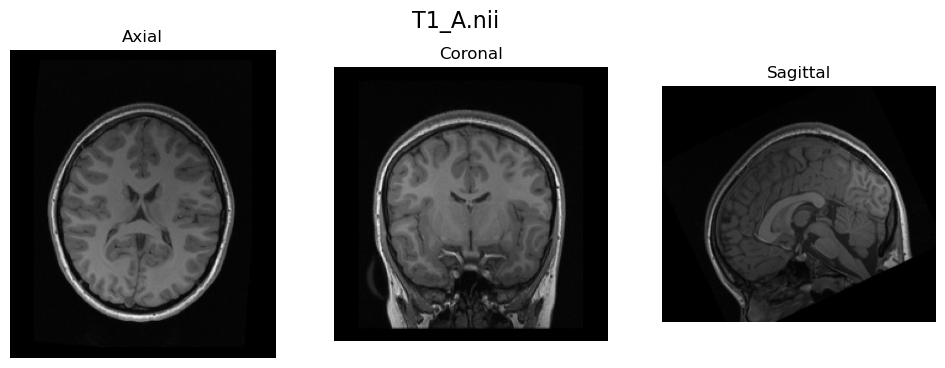

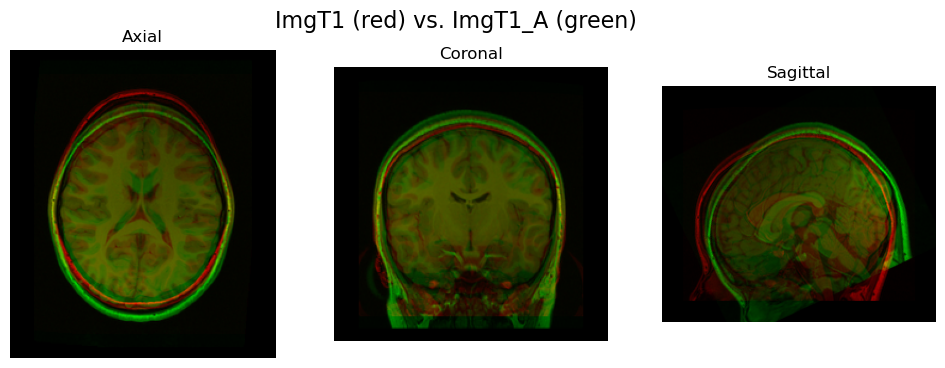

In [11]:
# exercise 4: visualise image from exercise 3
imshow_orthogonal_view(ImgT1_A, title='T1_A.nii')
overlay_slices(vol_sitk, ImgT1_A, title='ImgT1 (red) vs. ImgT1_A (green)')

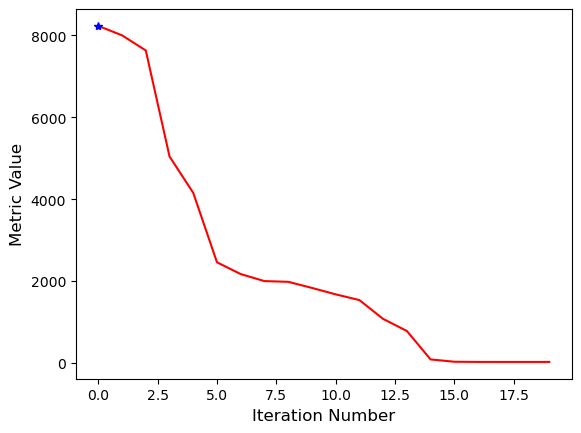

In [9]:
# Exercise 5: 

fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_A.nii')

# Set the registration method
R = sitk.ImageRegistrationMethod()

# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Set the initial transform 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to help with the iteration
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')
tform_reg.WriteTransform(dir_in + 'A1.tfm')
tform_loaded = sitk.ReadTransform(dir_in + 'A1.tfm')

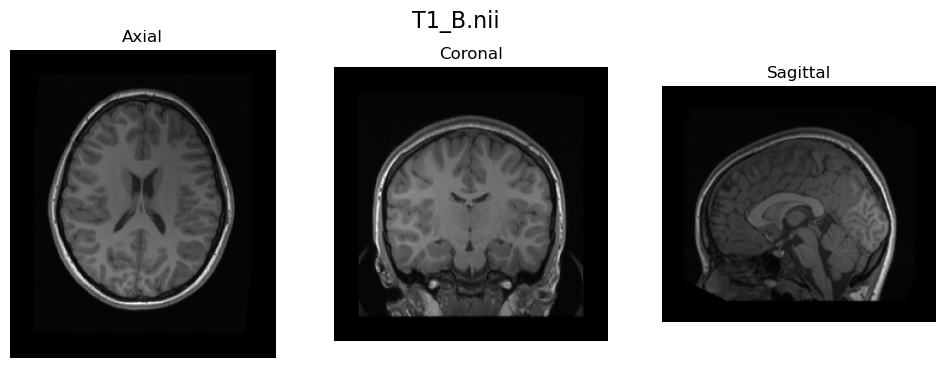

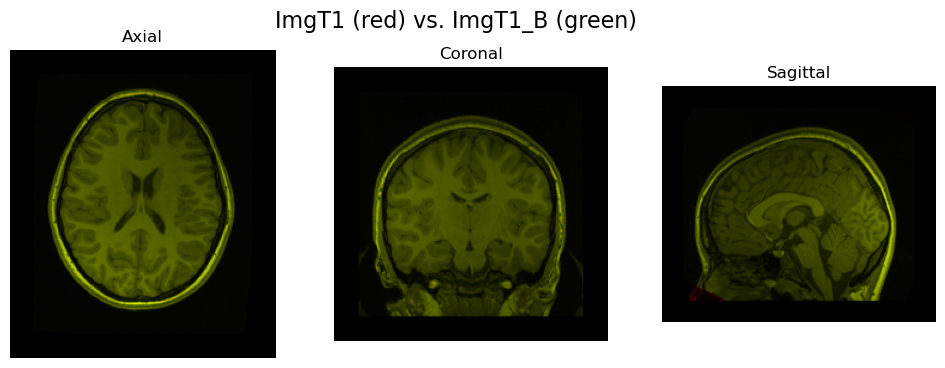

In [10]:
# exercise 6: show orthoview of ImgT1_B
imshow_orthogonal_view(ImgT1_B, title='T1_B.nii')
overlay_slices(fixed_image, ImgT1_B, title = 'ImgT1 (red) vs. ImgT1_B (green)')
tform_reg.WriteTransform(dir_in + 'A1.tfm')

In [11]:
# exercise 6: display optimal affine matrix found
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""
    matrix = np.zeros((4, 4))
    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))
    matrix[:3, 3] = transform.GetTranslation()
    matrix[3, 3] = 1
    return matrix

matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

# We expect the estimated matrix to be close to the inverse of the actual matrix
print('Estimated @ Actual: ')
print(np.round(matrix_applied @ matrix_estimated, 3))
# But we dont get the identity because the centre of rotations were different!
# All the difference is in the translation component

# We can also check the individual components of the estimated matrix
print(' ')
params = tform_reg.GetParameters()   # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)
angles = params[:3]
trans = params[3:6]
print('Estimated translation: ')
print(np.round(trans, 3))
print('Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 3))

Applied transformation matrix: 
[[ 1.    0.    0.    0.  ]
 [ 0.    0.91  0.42  0.  ]
 [ 0.   -0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated registration matrix: 
[[ 1.   -0.    0.   -0.  ]
 [ 0.    0.91 -0.42 11.16]
 [-0.    0.42  0.91 30.63]
 [ 0.    0.    0.    1.  ]]
Estimated @ Actual: 
[[ 1.    -0.     0.    -0.   ]
 [ 0.     1.    -0.    23.063]
 [-0.     0.     1.    23.043]
 [ 0.     0.     0.     1.   ]]
 
Estimated translation: 
[-0.    11.164 30.631]
Estimated rotation (deg): 
[2.5001e+01 1.0000e-03 0.0000e+00]


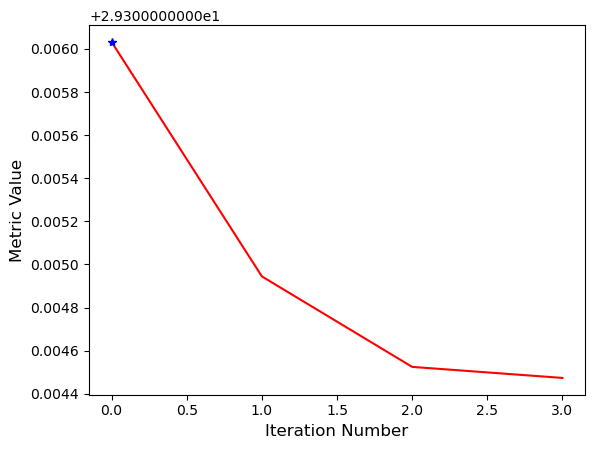

In [12]:
# exercise 7: change rotation center to center of image
# using sitk.CenteredTransformInitializer

fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_A.nii')

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Set the initial transform 
initTransform=sitk.CenteredTransformInitializer(fixed_image, moving_image, 
                                                 sitk.Euler3DTransform(), 
                                                 sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
R.AddCommand(sitk.sitkStartEvent, start_plot)
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

tform_reg = R.Execute(fixed_image, moving_image)
ImgT1_B = sitk.Resample(moving_image, tform_reg)

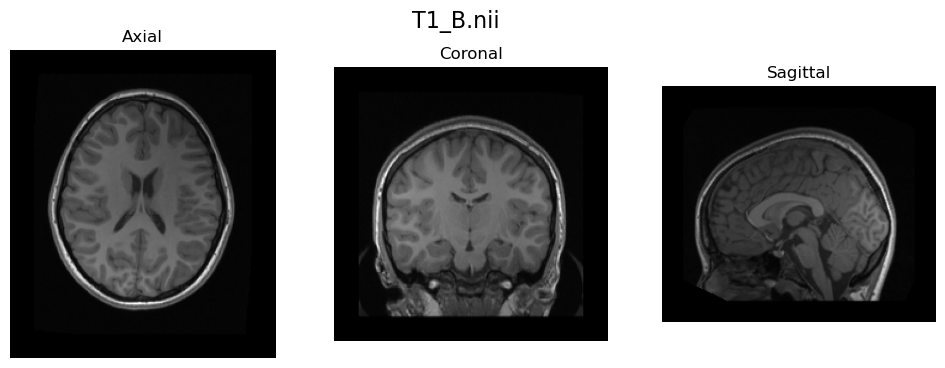

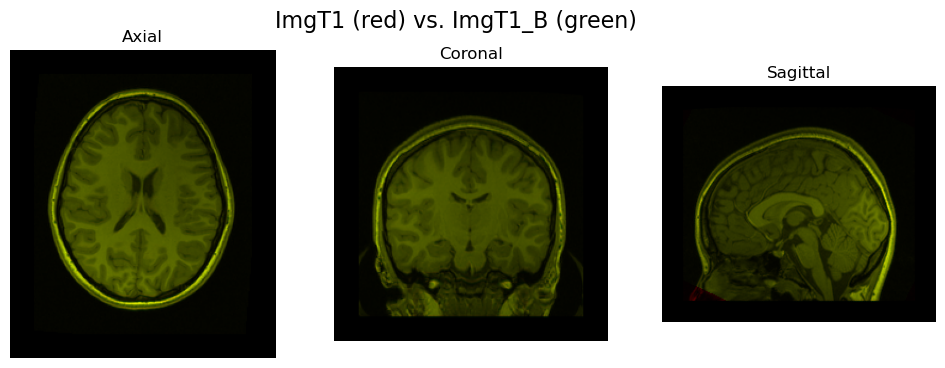

In [13]:
imshow_orthogonal_view(ImgT1_B, title='T1_B.nii')
overlay_slices(fixed_image, ImgT1_B, title = 'ImgT1 (red) vs. ImgT1_B (green)')

In [14]:
matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

# We expect the estimated matrix to be close to the inverse of the actual matrix
print('Estimated @ Actual: ')
print(np.round(matrix_applied @ matrix_estimated, 3)) # Should be identity matrix

# We can also check the individual components of the estimated matrix
print(' ')
params = tform_reg.GetParameters()
angles = params[:3]
trans = params[3:6]
print('Estimated translation: ')
print(np.round(trans, 2))
print('Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

Applied transformation matrix: 
[[ 1.    0.    0.    0.  ]
 [ 0.    0.91  0.42  0.  ]
 [ 0.   -0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated registration matrix: 
[[ 1.   -0.    0.    0.  ]
 [ 0.    0.91 -0.42 -0.  ]
 [ 0.    0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated @ Actual: 
[[ 1.    -0.     0.     0.   ]
 [ 0.     1.    -0.    -0.002]
 [-0.     0.     1.     0.003]
 [ 0.     0.     0.     1.   ]]
 
Estimated translation: 
[ 0. -0.  0.]
Estimated rotation (deg): 
[25. -0.  0.]


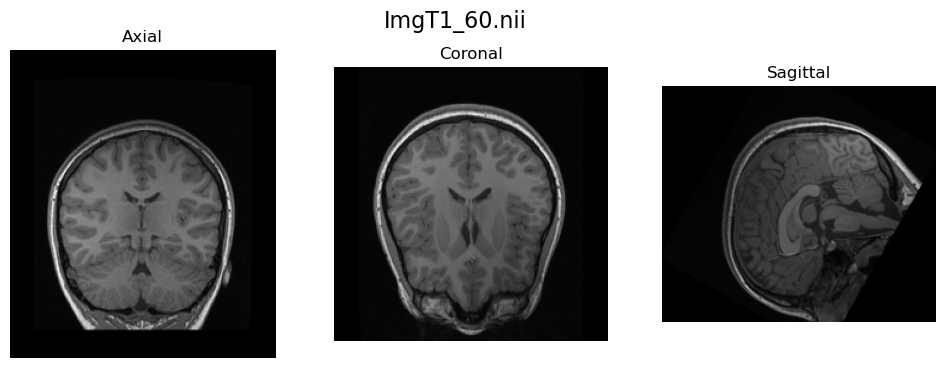

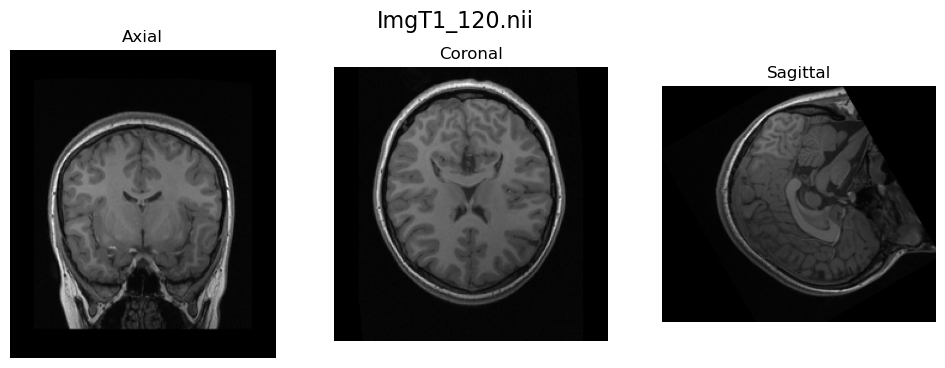

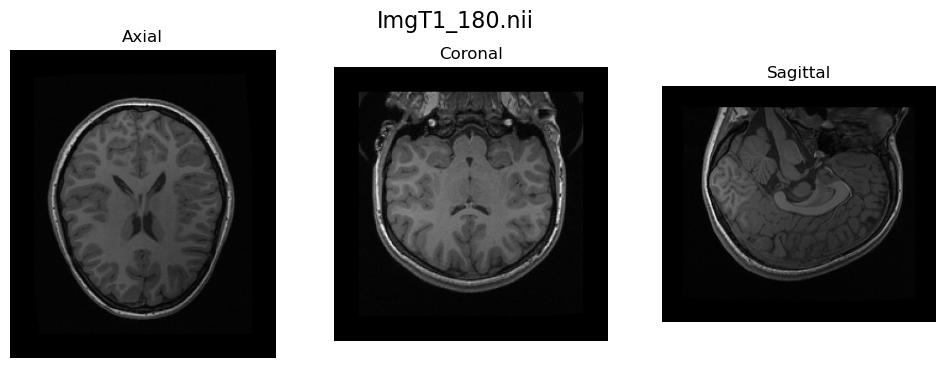

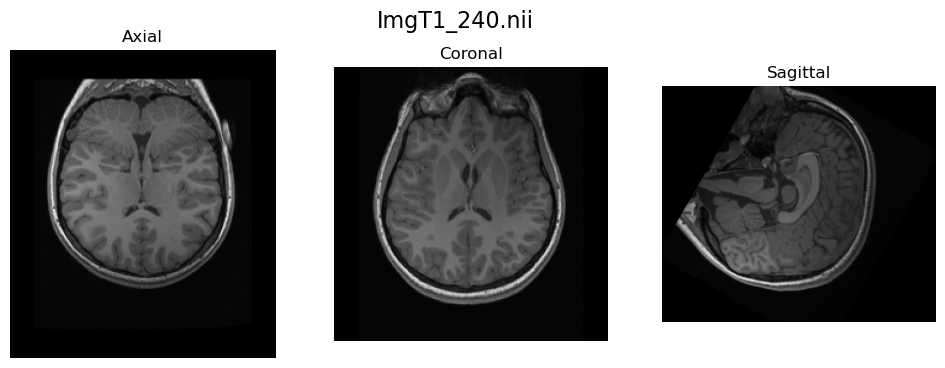

In [15]:
# Exercise 8: apply rotations in steps of 60 degrees

pitch_buffer = np.arange(1, 5)*60

for i, angle in enumerate(pitch_buffer):
    # Define the roll rotation in radians
    pitch_radians = np.deg2rad(angle)

    # Set the rotation
    centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
    centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
    rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

    # Create the Affine transform
    transform = sitk.AffineTransform(3)
    transform.SetCenter(centre_world) # Set the rotation centre
    transform.SetMatrix(rot_matrix.T.flatten())

    # Apply the transformation to the image
    output = sitk.Resample(vol_sitk, transform)

    # Visualize the rotated image
    imshow_orthogonal_view(output, title=f'ImgT1_{angle}.nii')
    
    # Save the rotated image
    sitk.WriteImage(output, f'{dir_in}ImgT1_{angle}.nii')

  0 = 12639.59576 : (0.0, -9.42483104985882, 40.31955565177039, 3.209313616743961, 2.3467523457591817, -1.675518230135641)
  1 = 12617.65991 : (0.0, -4.73573215574611, 20.19089043662547, 1.6046251828167122, 1.5948811464194286, -0.9289927651021501)
  2 = 12616.49826 : (0.0, -4.72407384033776, 20.177778289697436, 1.6051161436282637, 1.6118400503578623, -0.8833759400849853)
  3 = 12616.33365 : (0.0, -4.72407384033776, 20.177311340825234, 1.6047471884807387, 1.4980161180729483, -0.8833759400849853)
Estimated rotation (deg) for ImgT1_60.nii: 
[   0.    -270.669 1156.053]
  0 =   30.54799 : (39.79347645526495, -3.7229348645643584e-05, -1.7979478276612683e-05, 0.0008750115928183996, 0.0010948607647484185, 0.00094297252175126)
  1 =   30.54770 : (19.89674732953351, -1.3680177570769262e-05, -1.1354349669977172e-05, 0.0004082355283175145, 0.0007434297348036853, 0.00047148626087563)
Estimated rotation (deg) for ImgT1_180.nii: 
[ 1.14e+03 -1.00e-03 -1.00e-03]
  0 =   11.94705 : (41.88772139035636,

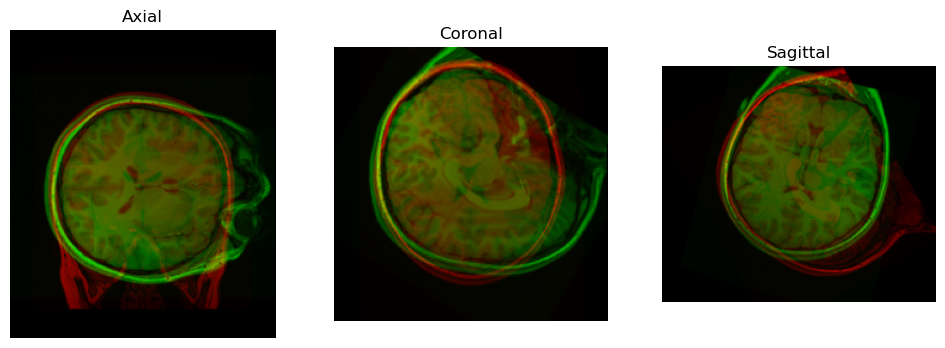

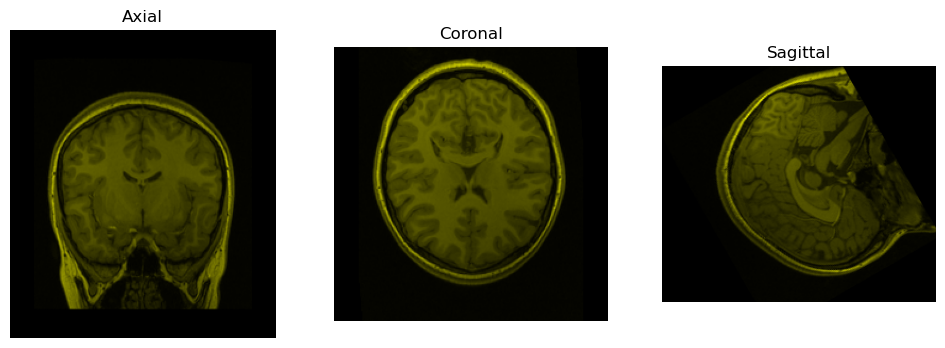

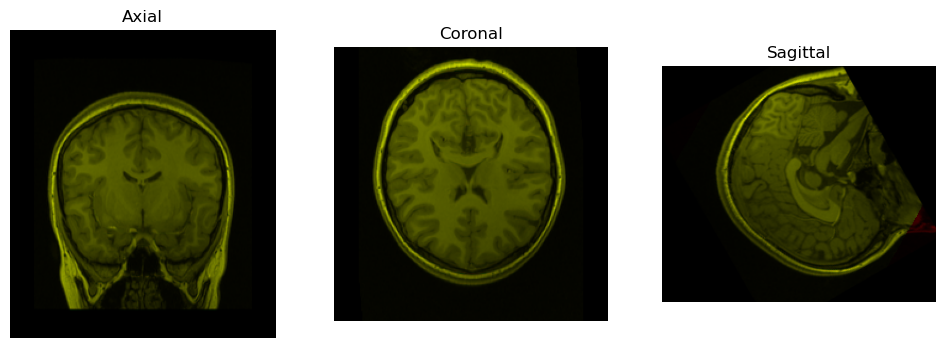

In [16]:
# Exercise 9: Run registration to find affine matrices of images generated in ex8

# Set the registration method
R = sitk.ImageRegistrationMethod()

# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=20, numberOfIterations=25)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration - Instead of a plot, we print
# iter = metric value : (Rx, Ry, Rz, Tx, Ty, Tz)
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

fixed_image = sitk.ReadImage(dir_in + 'ImgT1_120.nii')
pitch_buffer = np.array([60, 180, 240])
for i, angle in enumerate(pitch_buffer):
    
    moving_image = sitk.ReadImage(dir_in + f'ImgT1_{angle}.nii')

    # Set the initial transform 
    initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image, 
                                                     sitk.Euler3DTransform(), 
                                                     sitk.CenteredTransformInitializerFilter.GEOMETRY)
    R.SetInitialTransform(initTransform, inPlace=False)

    # Execute the registration
    tform_reg = R.Execute(fixed_image, moving_image)
    tform_reg.WriteTransform(dir_in + f'Ex9_{angle}.tfm')

    params = tform_reg.GetParameters()
    angles = params[:3]
    print(f'Estimated rotation (deg) for ImgT1_{angle}.nii: ')
    print(np.round(np.rad2deg(angles), 3))

    img_tmp = sitk.Resample(moving_image, tform_reg)
    # imshow_orthogonal_view(img_tmp, title=f'Registered ImgT1_{angle}.nii to ImgT1_120.nii')
    overlay_slices(fixed_image, img_tmp)

In [17]:
tform_60 = sitk.ReadTransform(dir_in + 'Ex9_60.tfm')
tform_180 = sitk.ReadTransform(dir_in + 'Ex9_180.tfm')
tform_240 = sitk.ReadTransform(dir_in + 'Ex9_240.tfm')

params = tform_60.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

params = tform_180.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

params = tform_240.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

Estimated rotation (deg): 
[   0.   -270.67 1156.05]
Estimated rotation (deg): 
[1140.   -0.   -0.]
Estimated rotation (deg): 
[1199.99   -0.     -0.  ]


  0 = 13574.44341 : (2.6221363723394365e-05, -1.2708193098707537e-05, -1.0228189057994928e-05, -0.38617721736501526, 30.701573657190234, -26.340922918054154)
  1 = 13441.70615 : (0.2532714222766171, 0.01037945968957646, 0.0009328527016932419, -0.190490157595646, 21.915142835613565, -19.348452032103413)
  2 = 13398.73994 : (0.15839655549446183, -0.0016638966675141522, 0.003583933568973813, -0.13814883167422645, 18.54209439559323, -15.569998885190348)
  3 = 13393.42866 : (0.14251941098685061, -0.0013501446905290677, 0.0001684719471340664, -0.039256043094425375, 18.420879197460486, -15.91195568796501)
  4 = 13393.22920 : (0.14233893237394096, 0.0001360467467574867, 0.0010921347980226387, -0.10218083621020792, 18.503402998911422, -15.913933914828505)
  5 = 13393.09862 : (0.1424291716803958, 0.0001708192168714016, 0.0011070108396504335, -0.09679420633204783, 18.480466511467284, -15.913638852796261)
  6 = 13393.02446 : (0.1424291716803958, 0.0001708192168714016, 0.0010619500841271088, -0.102

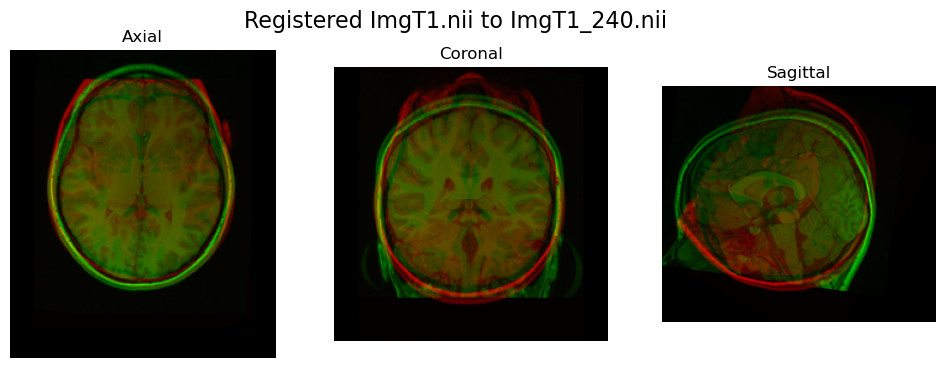

In [18]:
# Exercise 10: combine a series of affine matrices, reslicing only once

fixed_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Set the registration method
R = sitk.ImageRegistrationMethod()

# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=10, numberOfIterations=25)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image)
tform_reg.WriteTransform(dir_in + 'Ex10_0.tfm')

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image, tform_reg)
# imshow_orthogonal_view(img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')
overlay_slices(fixed_image, img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')

In [19]:
params = tform_reg.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

Estimated rotation (deg): 
[8.16 0.01 0.06]


In [20]:
# Exercise 10: combine a series of affine matrices

# Load the transforms from file
moving_image = sitk.ReadImage(dir_in + 'ImgT1.nii')

tform_60 = sitk.ReadTransform(dir_in + 'Ex9_60.tfm')
tform_180 = sitk.ReadTransform(dir_in + 'Ex9_180.tfm')
tform_240 = sitk.ReadTransform(dir_in + 'Ex9_240.tfm')
tform_0 = sitk.ReadTransform(dir_in + 'Ex10_0.tfm')

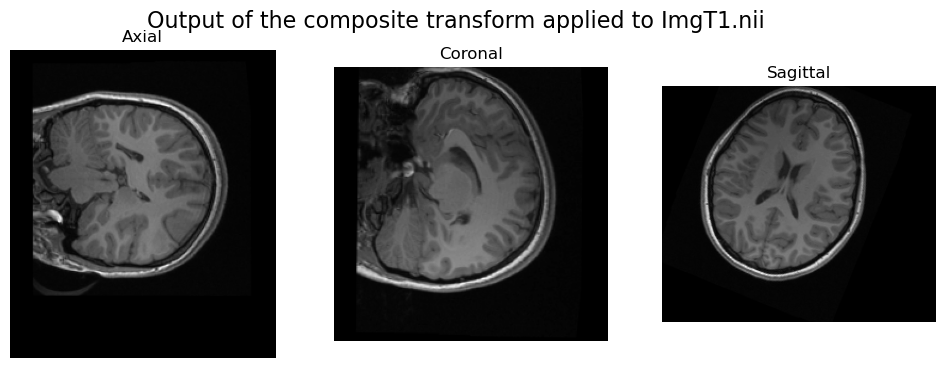

In [21]:
# Concatenate in an ITK way - The last added transform is applied first
tform_composite = sitk.CompositeTransform(3)

tform_composite.AddTransform(tform_240.GetNthTransform(0)) 
tform_composite.AddTransform(tform_180.GetNthTransform(0))
tform_composite.AddTransform(tform_60.GetNthTransform(0))
tform_composite.AddTransform(tform_0.GetNthTransform(0))

img_tmp = sitk.Resample(moving_image, tform_composite)
imshow_orthogonal_view(img_tmp, title='Output of the composite transform applied to ImgT1.nii')

In [22]:
affine_composite = composite2affine(tform_composite, centre_world)

# Since we are using just Euler transformations, 
# we can map it to a rigid transform
euler_composite = sitk.Euler3DTransform()
euler_composite.SetMatrix(affine_composite.GetMatrix())
euler_composite.SetTranslation(affine_composite.GetTranslation())
euler_composite.SetCenter(affine_composite.GetCenter())

params = euler_composite.GetParameters()
angles = params[:3]

print(f'Estimated rotation (deg) for the composite transformation: ')
print(np.round(np.rad2deg(angles), 2))

print(f'Estimated homogeneous matrix: ')
print(np.round(homogeneous_matrix_from_transform(euler_composite),2))

Estimated rotation (deg) for the composite transformation: 
[ -0.15 -90.64 112.1 ]
Estimated homogeneous matrix: 
[[ 0.000e+00 -9.300e-01  3.800e-01 -2.018e+01]
 [-1.000e-02 -3.800e-01 -9.300e-01  9.490e+00]
 [ 1.000e+00 -0.000e+00 -1.000e-02  9.700e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


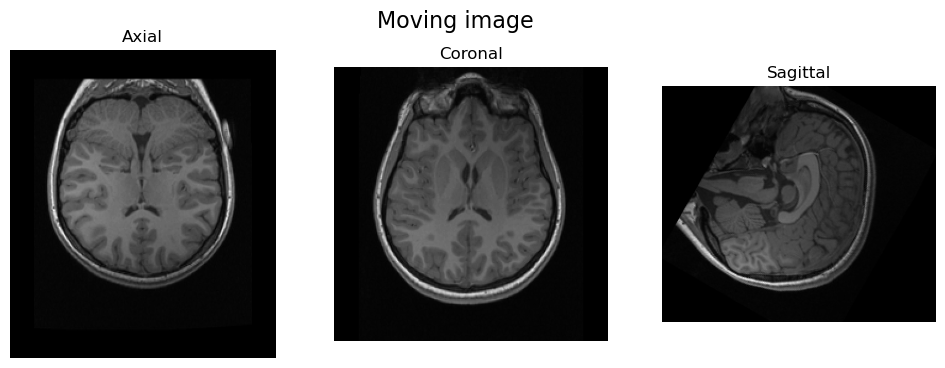

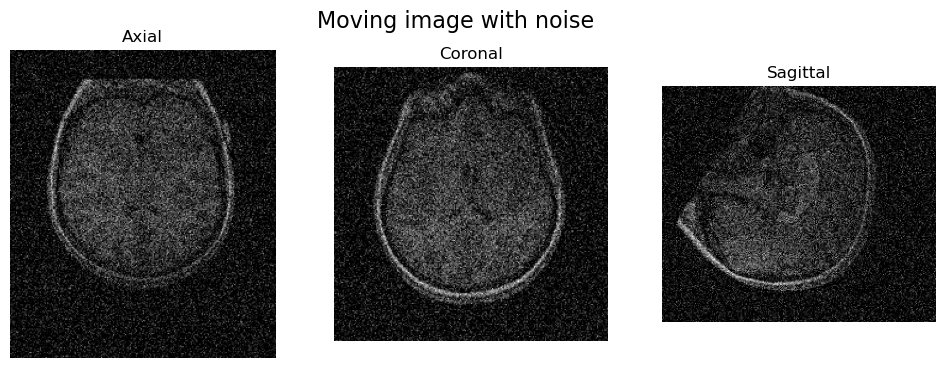

In [23]:
# Exercise 11: robustness in registration and number of iterations,
# generate noise in image

# Load the image
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')

# Add some noise to the moving image
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=200)
imshow_orthogonal_view(moving_image, title='Moving image')
imshow_orthogonal_view(moving_image_noisy, title='Moving image with noise')

sitk.WriteImage(moving_image_noisy, 'ImgT1_240_noisy.nii')



  0 = 11805.91854 : (-79.58899885721964, 0.00042687984331874667, -0.004910884770479655, 0.11201836439812583, 0.14270857615684057, -0.07493590218158278)
  1 = 11804.31382 : (-39.79449942860982, -0.0007464764801624349, -0.0024554423852398274, 0.05376624153348968, 0.07083421890175612, -0.027866735509785814)
  2 = 11800.31298 : (-39.79539860051455, -0.0003624609776349275, -0.0025201736384080683, 0.05363745900182123, 0.07113165904271733, -0.08848151564693264)
  3 = 11800.25596 : (-39.794949014562185, -0.00031448962844322914, -0.002487808011823948, 0.05385437584783565, 0.08335023922721, -0.06057442947361062)
  4 = 11800.23469 : (-39.794949014562185, -0.0002953689798562628, -0.002487808011823948, 0.054254111272767996, 0.07724228772164965, -0.060252470275150016)
Estimated rotation (deg) for ImgT1.nii: 
[-2.280083e+03 -1.700000e-02 -1.430000e-01]


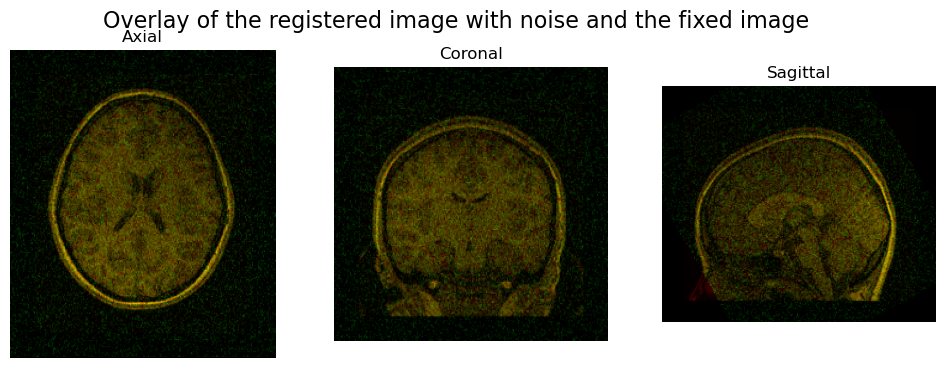

In [24]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')

noise_sigma = 200
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=noise_sigma)

# Set the registration method
R = sitk.ImageRegistrationMethod()

# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=200, numberOfIterations=10)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# R.SetShrinkFactorsPerLevel(shrinkFactors = [2,2,2])
# R.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,1,0])
# R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image_noisy, 
                                                 sitk.Euler3DTransform(), 
                                                 sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image_noisy)

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image_noisy, tform_reg)
overlay_slices(fixed_image, img_tmp, title='Overlay of the registered image with noise and the fixed image')

  0 =   37.21185 : (800.0587982865451, 0.00014390904826192926, 0.0, -0.005652312097495166, -0.008130601005689879, -0.00765894248244711)
  1 =   37.21114 : (400.02948077202467, 6.671101748713974e-05, 0.0, -0.0034714217025685274, -0.0017192122615544512, -0.004228807771480137)
  2 =   37.21102 : (400.02947528814343, 6.65528025288757e-05, 0.0, -0.0031995186358079386, -0.002028197790692921, -0.00432288173587094)
  3 =   37.21087 : (400.0294689906496, 5.981607877147071e-05, 0.0, -0.003423060818766889, -0.002116405940681189, -0.004577973080516116)
  4 =   37.21029 : (400.0294652467799, 4.6403215678139664e-05, 0.0, -0.003759305309709663, -0.0020888590118234673, -0.005082138724331269)
  5 =   37.21011 : (400.0294637450219, 3.6936023579938796e-05, 1.0072543640333438e-05, -0.0042910138273215825, -0.0019045917168528281, -0.004826050263741425)
  6 =   37.20979 : (400.0294588987672, 3.747036002110577e-05, 1.6311091131398502e-05, -0.004418511693933397, -0.001994923768422469, -0.00498064067742135)
  0

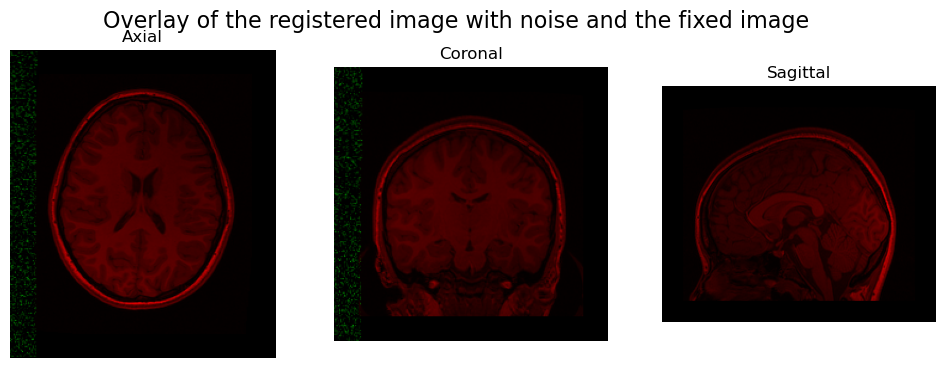

In [26]:
# Exercise 12: Register noisy moving image using pyramidal procedure

noise_sigma = 200
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=noise_sigma)

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=200, numberOfIterations=10) # stepLength= 10, 50, 150, 200

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2,2,2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,1,0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.10)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image_noisy, 
                                                 sitk.Euler3DTransform(),
                                                 sitk.CenteredTransformInitializerFilter.GEOMETRY)
# initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image_noisy)

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image_noisy, tform_reg)
overlay_slices(fixed_image, img_tmp, title='Overlay of the registered image with noise and the fixed image')

In [ ]:
# ??? Show the optimal affine matrices for each of the repeats to 
# check robustness.